# DeFungi Classification: Comparative Analysis Of CNN Architectures

## Introduction

DeFungi is a dataset for direct mycological examination of microscopic fungi images. The images are from superficial fungal infections caused by yeasts, moulds, or dermatophyte fungi. The images have been manually labelled into five classes and curated with a subject matter expert assistance. The images have been cropped with automated algorithms to produce the final dataset.

The DeFungi dataset is a collection of 9114 files of 5 classes
of fungal infections. They include:<br>Hypha 1 (H1) -> Tortuous septate hyaline hyphae (4404 images)<br>Hypha 2 (H2) -> Beaded arthroconidial septate hyaline
hyphae (2334 images)<br>Hypha 3 (H3) -> Groups or mosaics of arthroconidia (819
images)<br>Hypha 5 (H5) -> Septate hyaline hyphae with chlamydioconidia (818 images)<br>Hypha 6 (H6) -> Broad brown hyphae. (739 images)

## Importing Relevant Libraries

Here, we will load any libraries that are required for the entirety of the program in one-go.

In [1]:
import random
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

!pip install --root-user-action=ignore split-folders;
import splitfolders
import warnings
warnings.filterwarnings("ignore");



## Loading And Understanding The Dataset

We need to first download the dataset from the link of the dataset from UCI Machine Learning repository. It will be downloaded as a ZIP file which needs to be extracted as well.

In [2]:
!wget https://archive.ics.uci.edu/static/public/773/defungi.zip
!unzip defungi.zip;

Streaming output truncated to the last 5000 lines.
  inflating: H1/H1_94a_2.jpg         
  inflating: H1/H1_94a_3.jpg         
  inflating: H1/H1_94a_4.jpg         
  inflating: H1/H1_94a_5.jpg         
  inflating: H1/H1_94a_6.jpg         
  inflating: H1/H1_94a_7.jpg         
  inflating: H1/H1_94a_8.jpg         
  inflating: H1/H1_94a_9.jpg         
  inflating: H1/H1_94b_1.jpg         
  inflating: H1/H1_94b_2.jpg         
  inflating: H1/H1_94b_3.jpg         
  inflating: H1/H1_94b_4.jpg         
  inflating: H1/H1_94b_5.jpg         
  inflating: H1/H1_94b_6.jpg         
  inflating: H1/H1_94b_7.jpg         
  inflating: H1/H1_94b_8.jpg         
  inflating: H1/H1_94b_9.jpg         
  inflating: H1/H1_95a_1.jpg         
  inflating: H1/H1_95a_10.jpg        
  inflating: H1/H1_95a_11.jpg        
  inflating: H1/H1_95a_12.jpg        
  inflating: H1/H1_95a_13.jpg        
  inflating: H1/H1_95a_14.jpg        
  inflating: H1/H1_95a_15.jpg        
  inflating: H1/H1_95a_16.jpg        

Next, we need to split the folders into training and validation sets.

In [3]:
splitfolders.ratio("defungi", output="working", seed=42, ratio=(0.80, 0.20))

Copying files: 9114 files [00:01, 6714.14 files/s]


Now, we need to see the dimensions of the images we are dealing with.

In [4]:
im = cv2.imread('working/train/H1/H1_100a_1.jpg')
print(im.shape)

(500, 500, 3)


Next, we need to see the images from each class for visualisation purpose.

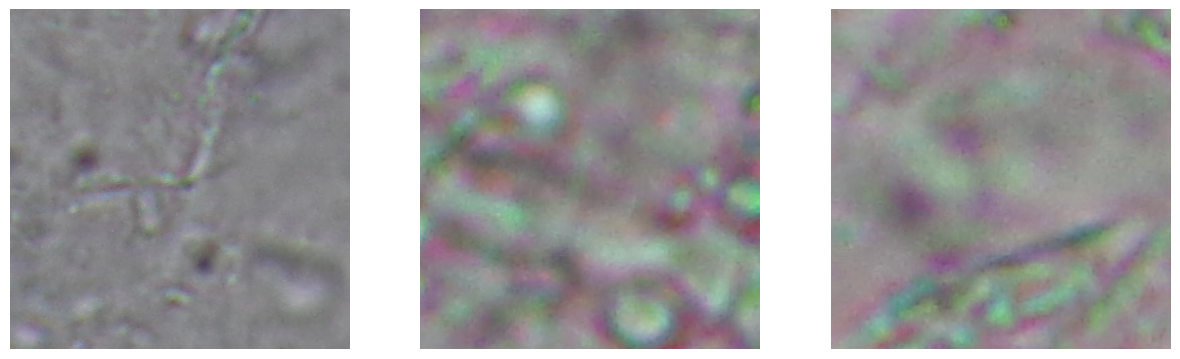

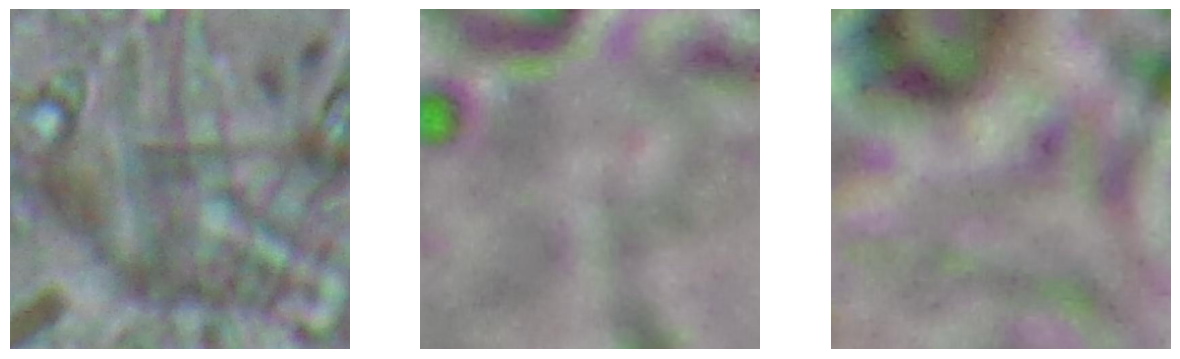

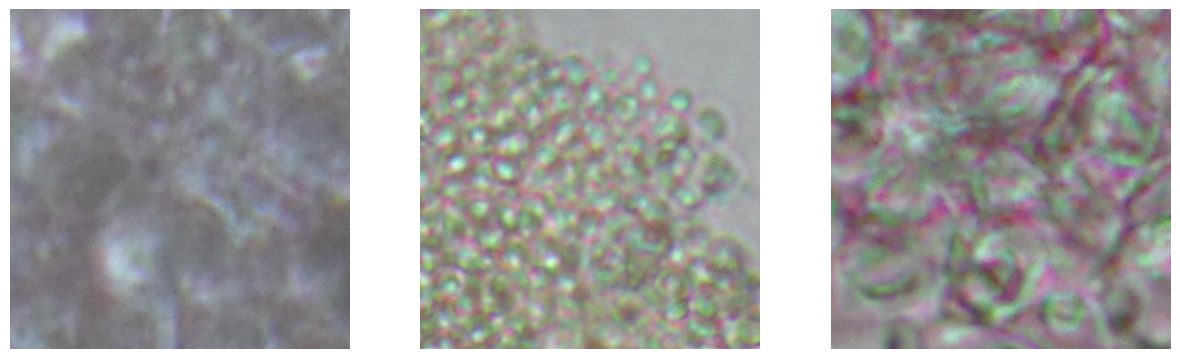

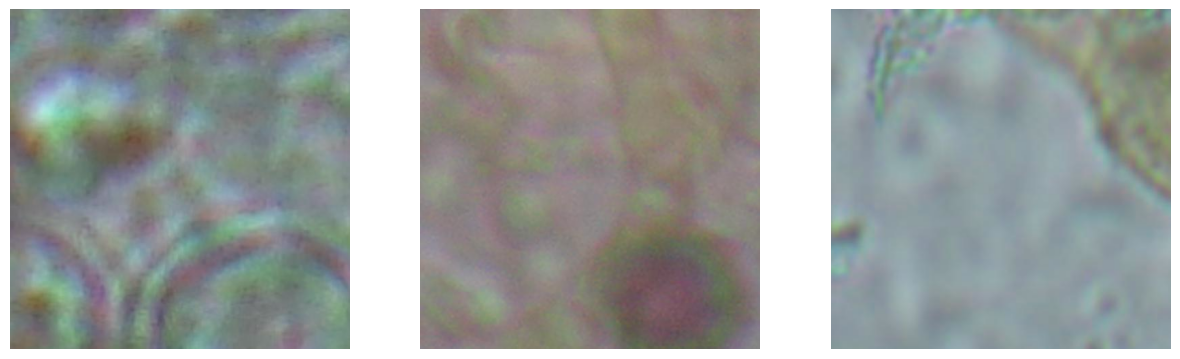

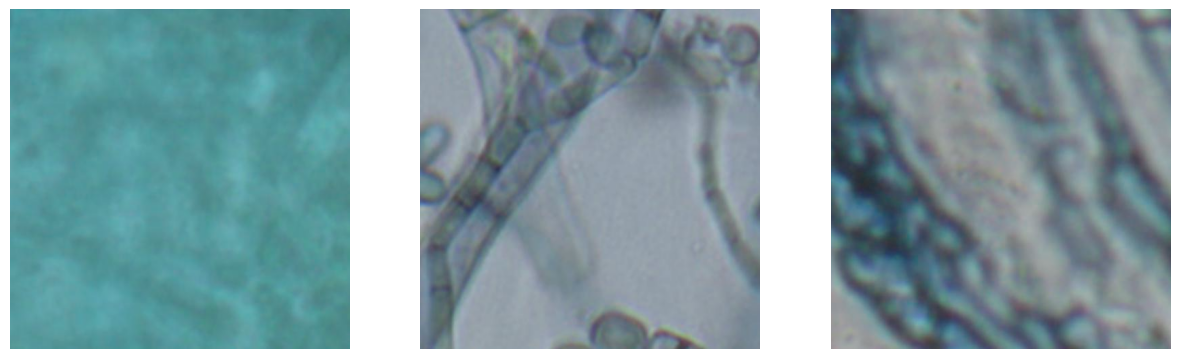

In [5]:
def plotImages2(multipleImages):
    r = random.sample(multipleImages, 9)
    plt.figure(figsize=(15,15))
    plt.subplot(331)
    plt.imshow(cv2.imread(r[0]));
    plt.axis('off')
    plt.subplot(332)
    plt.imshow(cv2.imread(r[1]));
    plt.axis('off')
    plt.subplot(333)
    plt.imshow(cv2.imread(r[2]));
    plt.axis('off')

plotImages2(glob('working/train/H1/**'))
plotImages2(glob('working/train/H2/**'))
plotImages2(glob('working/train/H3/**'))
plotImages2(glob('working/train/H5/**'))
plotImages2(glob('working/train/H6/**'))

## Developing Helper Functions

We need a few functions that we will be using again and again throughout the training and evaluation process.

First function is one that returns image generators that need to be used during training the model.

In [6]:
def generators(imageSize):
  data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                               horizontal_flip=True,
                                               vertical_flip=True)
  data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
  trainGenerator = data_generator_with_aug.flow_from_directory('working/train',
                                                               target_size=(imageSize, imageSize),
                                                               batch_size=32,
                                                               class_mode='categorical',
                                                               shuffle=True)
  validationGenerator = data_generator_no_aug.flow_from_directory('working/val',
                                                                  target_size=(imageSize, imageSize),
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  shuffle=True)
  return trainGenerator, validationGenerator

Second function displays the graph of training and validation loss over epochs.

In [7]:
def displayHistory(history):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  plt.figure(figsize=(10, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(30), acc, label='Training Accuracy')
  plt.plot(range(30), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(range(30), loss, label='Training Loss')
  plt.plot(range(30), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Transfer learning using ResNet-50

ResNet-50, a variant of the ResNet architecture known for its deep residual learning, played a crucial role in fine-grained classification within the DeFungi dataset. With 50 layers, including residual connections, ResNet-50 exhibited a remarkable ability to capture intricate details in fungal images.<br>This was made possible from the pre-trained weights (on the Image dataset) borrowed from the Keras framework. This made it particularly effective in discerning nuances among yeasts, moulds, and dermatophytes. The model’s performance in preserving gradient information during training, mitigating the vanishing gradient problem, contributed to its success in achieving high precision and recall values for specific fungal classes.<br>The images were resized to 224 by 224 (as it is the standard dimension ResNet50 was trained on), batch size was taken as 64 to make training more optimized and 80-20 split of training and validation set. The top layer of the weights was removed, and replaced with two dense layers and an output layer of softmax regression of 5.

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input
trainGenerator, validationGenerator = generators(224)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


Now, we create the customised transfer learning model.

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50;
resnet50ModelWeights = ResNet50(include_top=False,weights="imagenet")
x = resnet50ModelWeights.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
res = tf.keras.layers.Dense(5, activation="softmax")(x)
resnet50Model = Model(inputs=resnet50ModelWeights.input, outputs=res)
for layer in resnet50ModelWeights.layers:
  layer.trainable = False
resnet50Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']);

94765736/94765736 [==============================] - 0s 0us/step


Now we can train the model.

In [10]:
history = resnet50Model.fit(trainGenerator,
                            validation_data = validationGenerator,
                            epochs=30,
                            verbose=1).history

Epoch 1/30
228/228 [==============================] - 45s 152ms/step - loss: 0.9892 - accuracy: 0.6188 - val_loss: 0.7078 - val_accuracy: 0.7133
Epoch 2/30
228/228 [==============================] - 31s 136ms/step - loss: 0.7297 - accuracy: 0.7007 - val_loss: 0.6350 - val_accuracy: 0.7478
Epoch 3/30
228/228 [==============================] - 36s 158ms/step - loss: 0.6688 - accuracy: 0.7258 - val_loss: 0.6017 - val_accuracy: 0.7511
Epoch 4/30
228/228 [==============================] - 32s 140ms/step - loss: 0.6363 - accuracy: 0.7398 - val_loss: 0.6300 - val_accuracy: 0.7281
Epoch 5/30
228/228 [==============================] - 32s 142ms/step - loss: 0.6181 - accuracy: 0.7557 - val_loss: 0.5888 - val_accuracy: 0.7511
Epoch 6/30
228/228 [==============================] - 32s 140ms/step - loss: 0.5668 - accuracy: 0.7700 - val_loss: 0.5636 - val_accuracy: 0.7626
Epoch 7/30
228/228 [==============================] - 36s 159ms/step - loss: 0.5653 - accuracy: 0.7722 - val_loss: 0.5379 - val_ac

We can also view the model summary.

In [11]:
resnet50Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

Let's observe how the training and validation errors changed across different epochs.

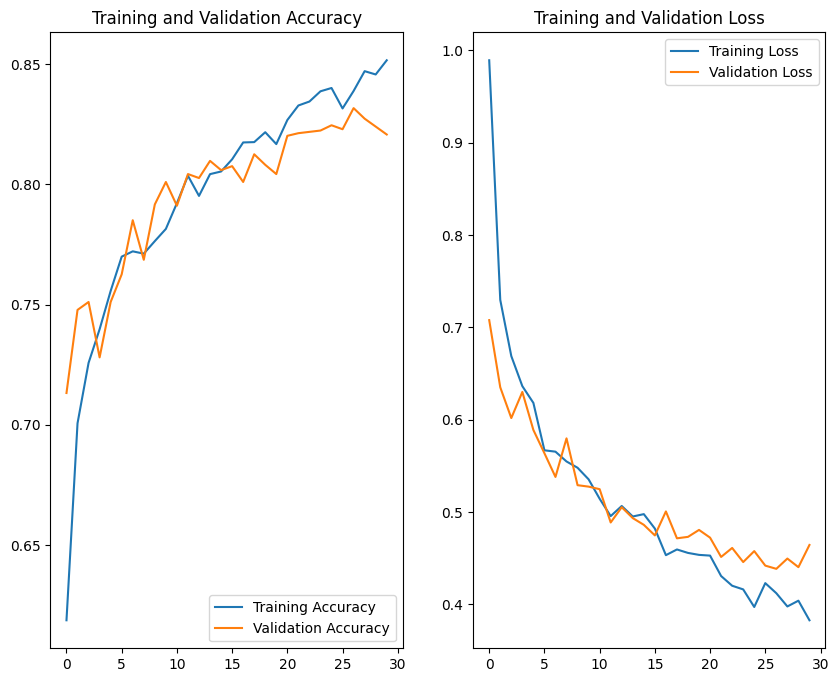

In [12]:
displayHistory(history)

After training for 30 epochs, the values seemed to converge by the 25th epoch. The model boasted a training set accuracy of 85.16% while a validation set accuracy of 82.07%. The loss was calculated to just 0.3827 on the training set.